<a href="https://colab.research.google.com/github/SangHee33/Sanghee2/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_4%EC%9E%A5_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

p.157-202

# 4. 모델 훈련

선형 회귀
- 직접 계산
- 경사 하강법

다항 회귀
- 선형 회귀보다 파라미터가 많아서 훈련 데이터에 과대적합되기 쉬움
- 학습 곡선을 사용해 모델이 과대적합되는지 감지

## 4.1 선형 회귀

- 선형 모델 = 입력 특성의 가중치 합 + 편향(절편)
- RMSE를 최소화하는 세타 찾기

### 4.1.1 정규방정식

- 비용 함수를 최소화하는 세타 값을 찾기 위한 해석적인 방법 -> 정규방정식 이용

In [21]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4+3*X +np.random.rand(100,1)

In [22]:
# 정규방정식을 이용해 세타 계산
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [23]:
theta_best

array([[4.56830717],
       [2.92624097]])

In [24]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] # 모든 샘플에 x0=1을 추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.56830717],
       [10.42078911]])

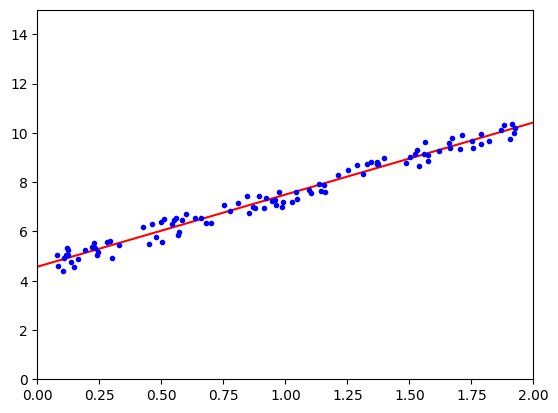

In [25]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_

(array([4.56830717]), array([[2.92624097]]))

In [27]:
lin_reg.predict(X_new)

array([[ 4.56830717],
       [10.42078911]])

In [28]:
# LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[4.56830717],
       [2.92624097]])

In [29]:
# 유사역행렬
np.linalg.pinv(X_b).dot(y)

array([[4.56830717],
       [2.92624097]])

### 4.1.2 계산 복잡도
- X.T * X의 역행렬을 계산하는 계산 복잡도는 일반적으로 O(n^2.4)에서 O(n^3) 사이임
- LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2)
- 예측하려는 샘플이 두 배로 늘어나면 걸리는 시간도 거의 두 배 증가

## 4.2 경사하강법
- 비용 함수를 최소화하기 위해 반복해서 파라미터 조정
- 그레이디언트가 0이 되면 최솟값에 도달
- 세타를 임의의 값으로 시작해서(무작위 초기화) 한 번에 조금씩 비용 함수가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렵할 때까지 점진적으로 향상시킴
- 중요한 파라미터는 스텝의 크기로, 학습률 하이퍼파라미터로 결정
- 학습률이 너무 작으면 반복을 많이 해야 하므로 시간이 오래 걸림
- 학습률이 너무 크면 알고리즘을 더 큰 값으로 발산시켜 해법 찾지 못함
- 무작위 초기화 때문에 알고리즘이 전역 최솟값보다 지역 최솟값에 수렴
- MSE 비용 함수는 볼록 함수라 지역 최솟값이 없고 하나의 전역 최솟값만 가짐
- 비용 함수를 최소화하는 모델 파라미터의 조합(파라미터 공간) 찾기

### 4.2.1 배치 경사 하강법
- 세타가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산 = 편도함수

In [30]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta = theta - eta*gradients

In [31]:
theta

array([[4.56830717],
       [2.92624097]])

- 적절한 학습률을 찾으려면 그리드 탐색
- 반복 횟수를 제한
- 벡터의 노름이 어떤 값(허용 오차)보다 작아지면 경사 하강법이 최솟값에 도달한 것이므로 알고리즘 중지

### 4.2.2 확률적 경사 하강법
- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트를 계산
- 배치 경사 하강법보다 불안정
- 담금질 기법 알고리즘과 유사
- 매 반복에서 학습률을 결정하는 함수를 학습 스케쥴

In [32]:
n_epochs=50
t0, t1 = 5, 50 #학습 스케줄 하이퍼 파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) #무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index=np.random.randint(m)
    xi=X_b[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    gradients=2*xi.T.dot(xi.dot(theta)-yi)
    eta=learning_schedule(epoch*m+i)
    theta=theta-eta*gradients

In [33]:
theta

array([[4.57225789],
       [2.92233243]])

- 각 반복은 에포크
- 한 에포크에서 여러 번 샘플이 선택될 수 있고 전혀 선택되지 못할 수도

In [34]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.54555215]), array([2.94817942]))

### 4.2.3 미니배치 경사 하강법
- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산

## 4.3 다항 회귀

In [35]:
# 2차방정식으로 비선형 데이터 생성
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2 + X + 2 + np.random.randn(m,1)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.69613035])

In [37]:
X_poly[0]

array([0.69613035, 0.48459746])

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([2.07184271]), array([[1.05872699, 0.43068565]]))

- PolynomialFeatures는 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문에 특성 사이의 관계를 찾을 수 있음

## 4.4 학습 곡선

- 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
  plt.legend(loc="upper right", fontsize=14)
  plt.xlabel("Train Set Size", fontsize=14)
  plt.ylabel("RMSE", fontsize=14)

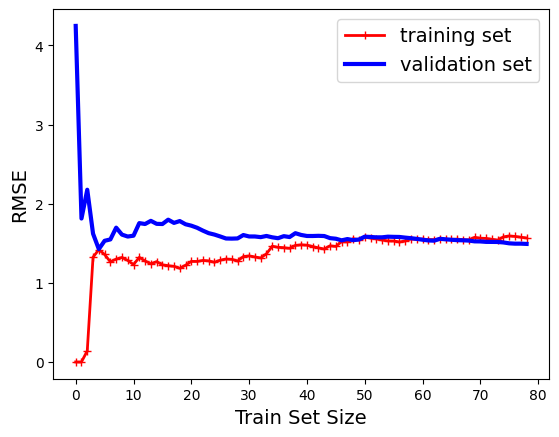

In [40]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

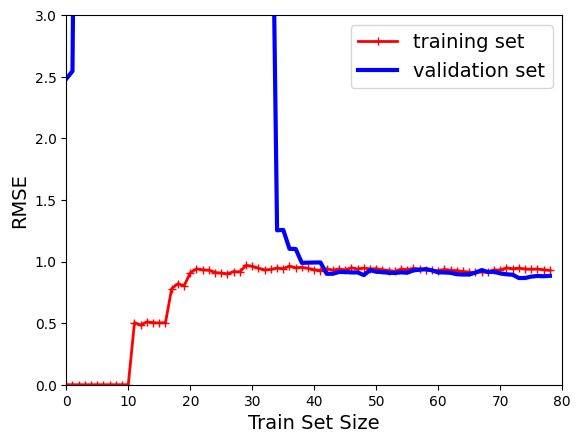

In [41]:
# 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()), ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이에 공간이 있음 -> 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 나음(과대적합 모델의 특징), 그러나 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐

## 4.5 규제가 있는 선형 모델
- 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것
- 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제
- '릿지 회귀', '라쏘 회귀', '엘라스틱넷'

### 4.5.1 릿지 회귀
- 규제가 추가된 선형 회귀 버전
- 학습 알고리즘을 데이터에 맞추고 모델의 가중치가 가능한 작게 유지되도록 노력
- 하이퍼파라미터 알파는 모델을 얼마나 많이 규제할지 조절
- 알파 = 0이면 릿지 회귀는 선형 회귀
- 알파가 아주 크면 모든 가중치가 거의 0에 가까워지고 데이터의 평균을 지나는 수평선이 됨

In [42]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.04626491]])

In [43]:
# 확률적 경사 하강법 사용
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.0243222])

### 4.5.2 라쏘 회귀
- 덜 중요한 특성의 가중치를 제거하려 함
- 자동으로 특성 선택을 하고 희소 모델을 만듦

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.00765146])

### 4.5.3 엘라스틱넷
- 릿지와 라쏘 회귀를 절충한 모델
- r=0이면 릿지 회귀와 같고 r=1이면 라쏘 회귀와 같음
- 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피함
- 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 나음
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷 선호

In [46]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.00503797])

### 4.5.4 조기 종료
- 경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 방법 중 하나는 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 조기 종료

In [47]:
# 조기 종료를 위한 기본적인 구현 코드
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)   # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

## 4.6 로지스틱 회귀
- 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측(레이블이 '1'인 양성 클래스), 아니면 클래스에 속하지 않는다고 예측(레이블이 '2'인 음성 클래스) -> 이진 분류기

### 4.6.1 확률 추정
- 입력 특성의 가중치 합을 계산
- 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력
- 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수

### 4.6.2 훈련과 비용 함수
- 훈련의 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것

### 4.6.3 결정 경계


In [49]:
# 꽃잎의 너비를 기반으로 아이리스 종을 감지하는 분류기
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [51]:
X = iris["data"][:,3:] # 꽃잎의 너비
y = (iris["target"]==2).astype(np.int) # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [52]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

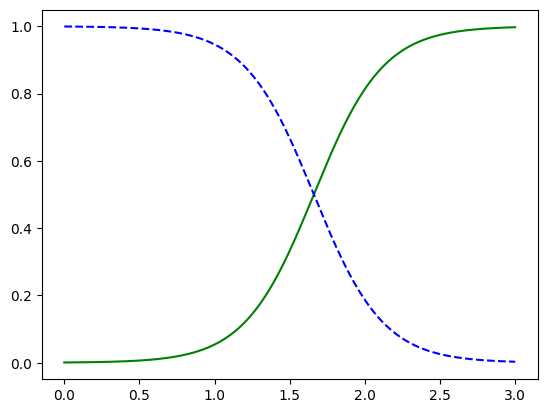

In [53]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0,  3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-",label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--",label="Not Iris virginica")

-> 꽃잎 너비가 1.6cm보다 크면 분류기는 Iris-Verginica로 분류

In [54]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀(다항 로지스틱 회귀)

- 샘플 x가 주어지면 소프트맥싀 회귀 모델이 각 클래스 k에 대한 점수를 계산하고 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정
- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적
- 크로스 엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 목적에 부합

In [55]:
X = iris['data'][:,(2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [56]:
softmax_reg.predict([[5, 2]])

array([2])

In [57]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])